In [ ]:
import numpy
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
## Neural network class
class PINN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(PINN, self).__init__()
    activation = nn.Tanh
    self.input_layer = nn.Linear(input_size, hidden_size)
    self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, hidden_size),activation()) for _ in range(num_layers)])
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, x, y):
    input_data = torch.cat((x, y), -1)
    output = torch.tanh(self.input_layer(input_data))
    for layer in self.hidden_layers:
      output = layer(output)
    final_output = self.output_layer(output)
    output1, output2 = torch.split(final_output, 1, dim=1)
    return output1, output2

In [ ]:
##Defining the Continuity Equation
def continuity_equation(u, v, x, y):
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]
    return u_x + v_y

In [ ]:
##Defining the X momentum Equation
def Xmomentum_equation(u, v, x, y, nu):
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u), create_graph=True)[0]
    return u*u_x + v*u_y - nu*u_yy

In [ ]:
## Initialization of PINN and constants
torch.manual_seed(69)
pinn = PINN(2,40,2,10)
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.0002)
u0 = 1
nu = 0.001

In [ ]:
## PDE training data
x1 = torch.linspace(0, 2, 41).view(-1, 1)
y1 = torch.linspace(0, 0.2, 41).view(-1, 1)
x1 = x1.view(-1)
y1 = y1.view(-1)
x_train1, y_train1 = torch.meshgrid(x1, y1)
x_train1 = x_train1.reshape(1681, 1).requires_grad_(True)
y_train1 = y_train1.reshape(1681, 1).requires_grad_(True)

In [ ]:
## y = 0 Boundary condition training data
x2 = torch.linspace(0, 2, 41).view(-1, 1)
y2 = torch.tensor(0.)
x2 = x2.view(-1)
y2 = y2.view(-1)
x_train2, y_train2 = torch.meshgrid(x2, y2)
x_train_y0 = x_train2.reshape(41, 1).requires_grad_(True)
y_train_y0 = y_train2.reshape(41, 1).requires_grad_(True)
u_train_y0 = 0
v_train_y0 = 0

In [ ]:
## y = 1 Boundary condition training data
x3 = torch.linspace(0, 2, 41).view(-1, 1)
y3 = torch.tensor(0.2)
x3 = x3.view(-1)
y3 = y3.view(-1)
x_train3, y_train3 = torch.meshgrid(x3, y3)
x_train_y1 = x_train3.reshape(41, 1).requires_grad_(True)
y_train_y1 = y_train3.reshape(41, 1).requires_grad_(True)
u_train_y1 = u0
v_train_y1_y = 0

In [ ]:
## x = 0 Boundary condition training data
y4 = torch.linspace(0, 0.2, 41).view(-1, 1)
x4 = torch.tensor(0.)
x4 = x4.view(-1)
y4 = y4.view(-1)
x_train4, y_train4 = torch.meshgrid(x4, y4)
x_train_x0 = x_train4.reshape(41, 1).requires_grad_(True)
y_train_x0 = y_train4.reshape(41, 1).requires_grad_(True)
u_train_x0 = u0
v_train_x0 = 0

In [ ]:
## Training Loop
epochs = 35000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  ## pde residual losses for continuity equation, momentum equation, and energy equation
  u_pred, v_pred = pinn(x_train1, y_train1)

  pde_loss1 = continuity_equation(u_pred, v_pred, x_train1, y_train1).pow(2).mean()
  pde_loss2 = Xmomentum_equation(u_pred, v_pred, x_train1, y_train1, nu).pow(2).mean()
  pde_loss = pde_loss1 + pde_loss2

  ## Boundary condition losses for for boundary y = 0
  u_pred_y0, v_pred_y0 = pinn(x_train_y0, y_train_y0)
  boundary_condition_loss_y0 = (u_pred_y0 - u_train_y0).pow(2).mean() + (v_pred_y0 - v_train_y0).pow(2).mean()

  ## Boundary condition losses for for boundary y = 0.2
  u_pred_y1, v_pred_y1 = pinn(x_train_y1, y_train_y1)
  v_pred_y1_y = torch.autograd.grad(v_pred_y1, y_train_y1, torch.ones_like(v_pred_y1), create_graph=True)[0]
  boundary_condition_loss_y1 = (u_pred_y1 - u_train_y1).pow(2).mean() + (v_pred_y1_y - v_train_y1_y).pow(2).mean()

  ## Boundary condition losses for for boundary x = 0
  u_pred_x0, v_pred_x0 = pinn(x_train_x0, y_train_x0)
  boundary_condition_loss_x0 = (u_pred_x0 - u_train_x0).pow(2).mean() + (v_pred_x0 - v_train_x0).pow(2).mean()

  p1 = 10
  boundary_condition_loss = boundary_condition_loss_y0 + boundary_condition_loss_y1 + boundary_condition_loss_x0
  total_loss = pde_loss + p1*boundary_condition_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 2500 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}")

Epoch 0/35000, Total Loss: 20.707508087158203, pde Loss: 4.602923198149256e-08, Boundary Loss: 2.0707507133483887
Epoch 2500/35000, Total Loss: 0.1477775275707245, pde Loss: 0.004544053226709366, Boundary Loss: 0.014323348179459572
Epoch 5000/35000, Total Loss: 0.13417166471481323, pde Loss: 0.0017091347835958004, Boundary Loss: 0.01324625313282013
Epoch 7500/35000, Total Loss: 0.13457012176513672, pde Loss: 0.0019678466487675905, Boundary Loss: 0.01326022669672966
Epoch 10000/35000, Total Loss: 0.1325102001428604, pde Loss: 0.0017732908017933369, Boundary Loss: 0.013073690235614777
Epoch 12500/35000, Total Loss: 0.1301613301038742, pde Loss: 0.001352675724774599, Boundary Loss: 0.01288086548447609
Epoch 15000/35000, Total Loss: 0.12642614543437958, pde Loss: 0.00071065773954615, Boundary Loss: 0.012571549043059349
Epoch 17500/35000, Total Loss: 0.12367718666791916, pde Loss: 0.0004379177698865533, Boundary Loss: 0.012323927134275436
Epoch 20000/35000, Total Loss: 0.13098859786987305, 

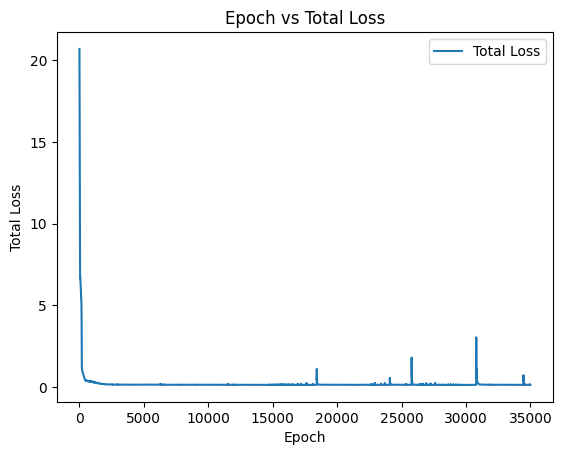

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    x_plot = torch.linspace(0, 2, 41)
    y_plot = torch.linspace(0, 0.2, 41)
    X, Y = torch.meshgrid(x_plot, y_plot)
    xy_combined = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)
    u_pred_plot, v_pred_plot = pinn(xy_combined[:, 0].unsqueeze(1), xy_combined[:, 1].unsqueeze(1))

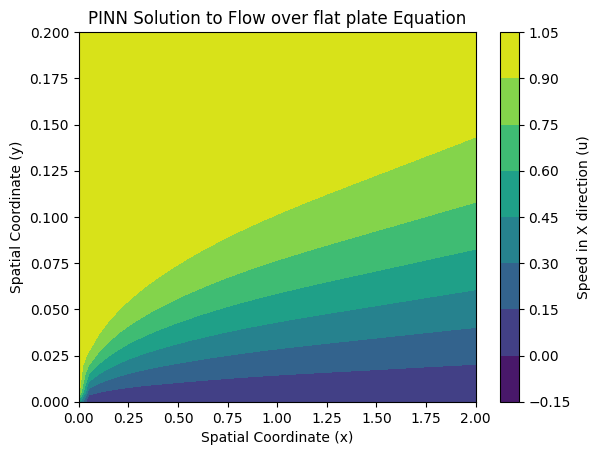

In [ ]:
## 2D contour plot
plt.figure()
contour = plt.contourf(X.numpy(), Y.numpy(), u_pred_plot.reshape(X.shape), cmap='viridis')
plt.colorbar(contour, label='Speed in X direction (u)')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Spatial Coordinate (y)')
plt.title('PINN Solution to Flow over flat plate Equation')
plt.show()

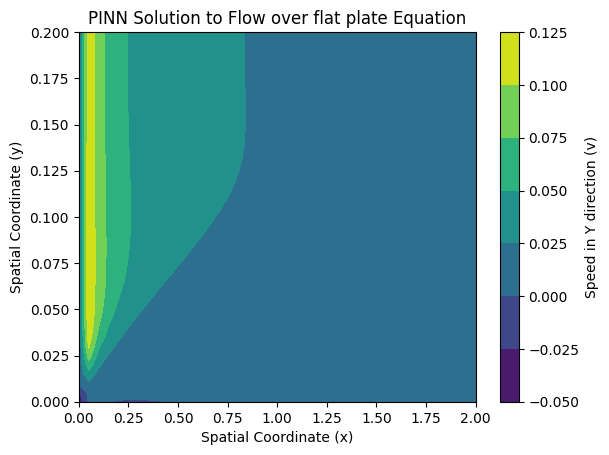

In [ ]:
## 2D contour plot
plt.figure()
contour = plt.contourf(X.numpy(), Y.numpy(), v_pred_plot.reshape(X.shape), cmap='viridis')
plt.colorbar(contour, label='Speed in Y direction (v)')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Spatial Coordinate (y)')
plt.title('PINN Solution to Flow over flat plate Equation')
plt.show()

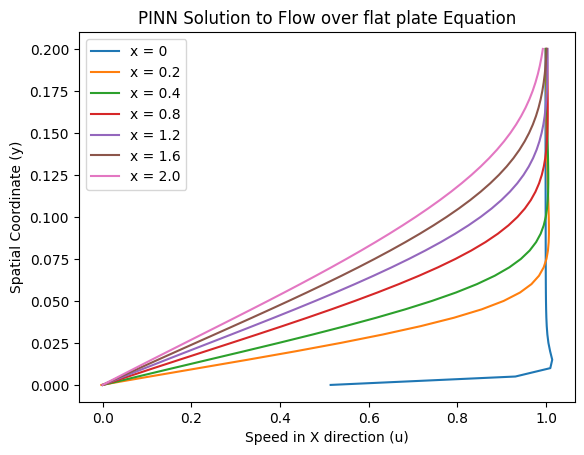

In [ ]:
with torch.no_grad():
    y_plot2 = torch.linspace(0, 0.2, 41)
    x_points = [0, 0.2, 0.4, 0.8, 1.2, 1.6, 2.0]

    plt.figure()

    for x_point in x_points:
        x_plot2 = torch.ones_like(y_plot2) * x_point
        xy_combined = torch.cat([x_plot2.reshape(-1, 1), y_plot2.reshape(-1, 1)], dim=1)

        u_pred_plot2, _ = pinn(xy_combined[:, 0].unsqueeze(1), xy_combined[:, 1].unsqueeze(1))

        plt.plot(u_pred_plot2, y_plot2.numpy(), label=f'x = {x_point}')

    plt.xlabel('Speed in X direction (u)')
    plt.ylabel('Spatial Coordinate (y)')
    plt.title('PINN Solution to Flow over flat plate Equation')
    plt.legend()
    plt.show()

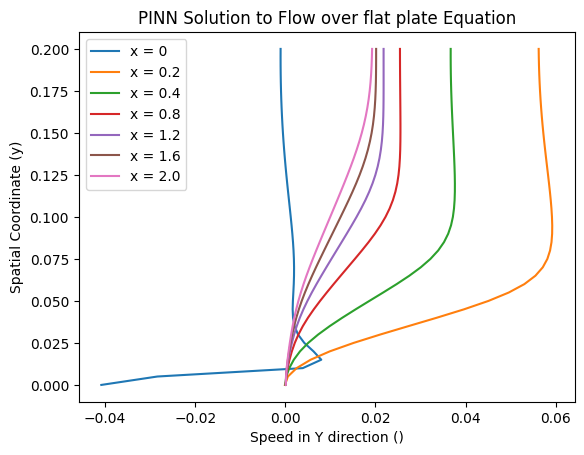

In [ ]:
with torch.no_grad():
    y_plot2 = torch.linspace(0, 0.2, 41)
    x_points = [0, 0.2, 0.4, 0.8, 1.2, 1.6, 2.0]

    plt.figure()

    for x_point in x_points:
        x_plot2 = torch.ones_like(y_plot2) * x_point
        xy_combined = torch.cat([x_plot2.reshape(-1, 1), y_plot2.reshape(-1, 1)], dim=1)

        _, v_pred_plot2 = pinn(xy_combined[:, 0].unsqueeze(1), xy_combined[:, 1].unsqueeze(1))

        plt.plot(v_pred_plot2, y_plot2.numpy(), label=f'x = {x_point}')

    plt.xlabel('Speed in Y direction ()')
    plt.ylabel('Spatial Coordinate (y)')
    plt.title('PINN Solution to Flow over flat plate Equation')
    plt.legend()
    plt.show()

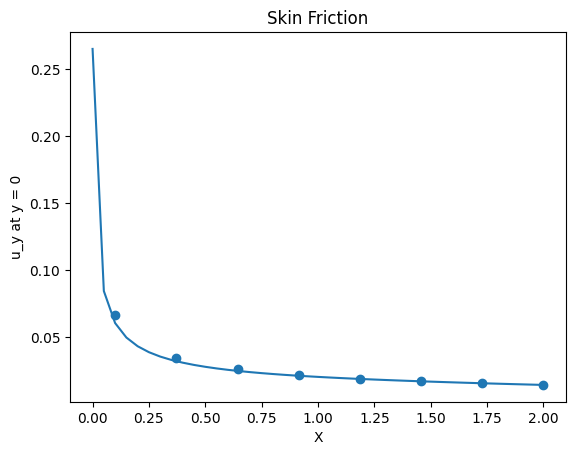

In [ ]:
x_plot3 = torch.linspace(0, 2, 41)
y_plot3 = torch.linspace(0, 0.2, 41)
X3, Y3 = torch.meshgrid(x_plot3, y_plot3)
Y3 = Y3.requires_grad_(True)
xy3_combined = torch.cat([X3.reshape(-1, 1), Y3.reshape(-1, 1)], dim=1)
u_pred_plot3, v_pred_plot3 = pinn(xy3_combined[:, 0].unsqueeze(1), xy3_combined[:, 1].unsqueeze(1))
u_pred_plot3 = u_pred_plot3.reshape(41,41)
u_pred_plot3_y = torch.autograd.grad(u_pred_plot3, Y3, torch.ones_like(u_pred_plot3), create_graph=True)[0]
u_pred_plot3_y = u_pred_plot3_y[:, 0]
plt.plot(x_plot3.detach().numpy(), 2*nu*(u_pred_plot3_y.detach().numpy())/u0**2)
plt.scatter(numpy.linspace(0.1,2,8), 0.664/numpy.sqrt(u0*numpy.linspace(0.1,2,8)/nu))
plt.xlabel('X')
plt.ylabel('u_y at y = 0')
plt.title('Skin Friction')
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bl_convection.txt to bl_convection.txt


In [ ]:
file_path = '/content/bl_convection.txt'
delimiter = '    '
selected_columns = [0, 2]
selected_data = []

import pandas as pd
with open(file_path, 'r') as file:
    for line_number, line in enumerate(file, 1):
        columns = line.strip().split('    ')
        selected_values = [columns[i] for i in selected_columns]
        selected_data.append(selected_values)
column_names = ['eta', 'f_prime']
df_selected = pd.DataFrame(selected_data, columns=column_names)

df_copy  = df_selected
df_copy = df_copy.astype(str)

def apply(val):
  val_copy = val.split('D')
  return float(val_copy[0])*(10**(float(val_copy[1])))

df_copy = df_copy.applymap(apply)

column_arrays = [df_copy.iloc[:, i].to_numpy() for i in range(df_selected.shape[1])]
column_1_array = column_arrays[0]
column_2_array = column_arrays[1]
column_1_arrayc = column_1_array[::1000]
column_2_arrayc = column_2_array[::1000]
eta = Y * torch.sqrt(u0/(nu*X))
eta_plot = torch.tensor(column_1_arrayc, dtype=torch.float32).reshape(1001,1)
f_prime_plot = torch.tensor(column_2_arrayc, dtype=torch.float32).reshape(1001,1)
u_pred_plot = (u_pred_plot.reshape(1681,1).detach().numpy()*100)/100
eta = (eta.reshape(1681,1).detach().numpy()*100)/100

In [ ]:
column_1_array = column_1_array[::100000]
column_2_array = column_2_array[::100000]
eta_plot2 = torch.tensor(column_1_array, dtype=torch.float32).reshape(11,1)
f_prime_plot2 = torch.tensor(column_2_array, dtype=torch.float32).reshape(11,1)

In [ ]:
sorted_pairs = sorted(zip(eta, u_pred_plot))
sorted_eta, sorted_u_plot = zip(*sorted_pairs)

sorted_eta = numpy.array(sorted_eta)
sorted_u_plot = numpy.array(sorted_u_plot)

sorted_eta = numpy.trunc(sorted_eta * 10**2) / 10**2
sorted_u_plot = numpy.trunc(sorted_u_plot * 10**3) / 10**3

In [ ]:
# eta = Y * torch.sqrt(u0/(nu*X))

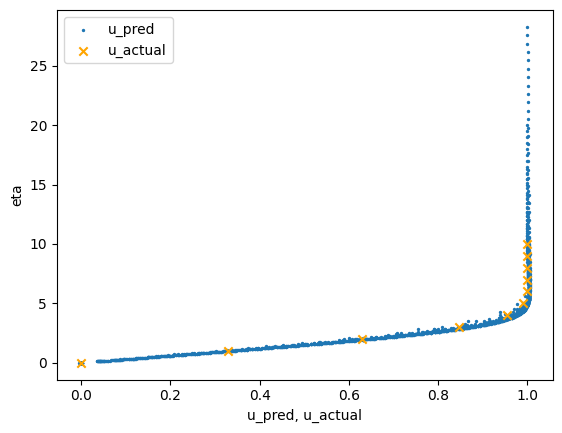

In [ ]:
plt.scatter(sorted_u_plot, sorted_eta, label="u_pred", marker = 'o', s = 2)
plt.scatter(f_prime_plot2, eta_plot2, color='orange', label="u_actual", marker='x')
plt.xlabel("u_pred, u_actual")
plt.ylabel("eta")
plt.legend()
plt.show()

In [ ]:
print(sorted_u_plot)
print(sorted_eta)

[[ 0.514]
 [-0.004]
 [-0.003]
 ...
 [ 1.009]
 [ 1.009]
 [ 1.014]]
[[nan]
 [ 0.]
 [ 0.]
 ...
 [inf]
 [inf]
 [inf]]


In [ ]:
import numpy as np
print("sorted_eta:", sorted_eta)
print("eta_plot:", eta_plot)
eta_plot = eta_plot.detach().numpy()
f_prime_plot = f_prime_plot.detach().numpy()
count = 0
for X in sorted_eta:
    # print("Checking X:", X)
    indices_eta_plot = np.atleast_1d(np.where(eta_plot == X))[0]
    # print("Indices found:", indices_eta_plot)
    for index_X2 in indices_eta_plot:
        print(f"sorted_eta: {X}, u_pred_plot: {sorted_u_plot[sorted_eta == X][0]}, f_prime_plot: {f_prime_plot[index_X2]}")
        mean_error = (sorted_u_plot[sorted_eta == X][0] - f_prime_plot[index_X2])**2
        count = count + 1
mean_error = mean_error/count

sorted_eta: [[nan]
 [ 0.]
 [ 0.]
 ...
 [inf]
 [inf]
 [inf]]
eta_plot: tensor([[0.0000e+00],
        [1.0000e-02],
        [2.0000e-02],
        ...,
        [9.9800e+00],
        [9.9900e+00],
        [1.0000e+01]])
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, f_prime_plot: [0.]
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, f_prime_plot: [0.]
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, f_prime_plot: [0.]
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, f_prime_plot: [0.]
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, f_prime_plot: [0.]
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, f_prime_plot: [0.]
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, f_prime_plot: [0.]
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, f_prime_plot: [0.]
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, f_prime_plot: [0.]
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, f_prime_plot: [0.]
sorted_eta: [0.], u_pred_plot: -0.004000000189989805, 

In [ ]:
print(mean_error*count)

[0.]
